![Logo BV IBMEC](https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/logo-bv-ibmec-notebooks.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ian-iania/IBMEC-BV-Modelos-Preditivos/blob/main/notebooks/NB03_Survival.ipynb)

# NB03 — Survival Analysis: Prepay e Duração da Carteira (Auto com LTV)

- entender evento “quando?” com censura
- ler curva Kaplan–Meier (S(t)) executivamente
- relacionar Selic+LTV com duração e impacto em planejamento/NII proxy


### Diretriz de visual

- **Plotly** para curvas e comparações (KM, grupos, validação, barras de NII).
- **Matplotlib** apenas para histogramas simples.
- Se algum plot não renderizar, reinicie o runtime no Colab e rode novamente.


## 1) Contexto FP&A

- Regressão: **quanto**
- Classificação: **se**
- Survival: **quando**

Prepay encurta duração da carteira, o que pode reduzir juros futuros e afetar NII.


### 1.1) Instalar pacote de survival

**O que:** instalar `lifelines` (KM).  
**Por que:** precisamos do Kaplan–Meier.  
**O que ver:** instalação concluída no output.


In [1]:
!pip -q install lifelines


pip stub: skipping install -q install lifelines


### 1.2) Imports

**O que:** carregar bibliotecas de dados, curvas e survival.  
**Por que:** base para toda a análise.  
**O que ver:** mensagem de ambiente pronto.


In [2]:
import pandas as pd  # manipulação de dados tabulares
import numpy as np  # operações numéricas
import matplotlib.pyplot as plt  # histogramas simples

import plotly.express as px  # gráficos rápidos (barras)
import plotly.graph_objects as go  # curvas customizadas

from lifelines import KaplanMeierFitter  # Kaplan-Meier survival

print('Bibliotecas carregadas com sucesso.')


Bibliotecas carregadas com sucesso.


## 2) Sanidade do dataset

Vamos carregar, ordenar por `orig_dt` e fazer um check inicial.


### 2.1) Carregar base raw do GitHub

**O que:** ler CSV oficial da aula.  
**Por que:** mesma base para toda turma.  
**O que ver:** shape e colunas esperadas.


In [3]:
url = 'https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/data/bv_auto_prepay_survival_sintetico.csv'

df = pd.read_csv(url, parse_dates=['orig_dt'])  # lê base com data já parseada

df = df.sort_values('orig_dt').reset_index(drop=True)  # ordena por originação

print(f'Shape: {df.shape[0]:,} linhas x {df.shape[1]} colunas')
print('Colunas principais:', ['orig_dt', 'T_meses', 'E_prepay', 'ltv', 'selic_at_orig'])


Shape: 30,000 linhas x 19 colunas
Colunas principais: ['orig_dt', 'T_meses', 'E_prepay', 'ltv', 'selic_at_orig']


### 2.2) Primeira visão e taxas de evento/censura

**O que ver:** taxa de `E_prepay` e taxa de censura (`1-E`).


In [4]:
event_rate = df['E_prepay'].mean()  # taxa de evento observado
censor_rate = 1 - event_rate  # taxa de censura

print(f'Taxa de evento E_prepay: {event_rate:.2%}')
print(f'Taxa de censura       : {censor_rate:.2%}')

df.head(5)


Taxa de evento E_prepay: 43.60%
Taxa de censura       : 56.40%


,id,orig_dt,term_meses,car_value,loan_amount,ltv,selic_at_orig,idade,renda_mensal,score_interno,canal,taxa_mensal_contrato,rate_spread_m,funding_proxy_m,parcela_mensal,pti,margin_monthly_proxy,T_meses,E_prepay
0,1,2019-01-01,24,57809.325442,45739.353212,0.791211,7.844555,70,2386.025186,618,parceiro,0.017541,0.011004,0.004576,2642.651352,0.800000,593.000377,3,1
1,13,2019-01-01,48,176694.669510,138008.598805,0.781057,7.424468,26,4737.772106,719,agencia,0.010676,0.004489,0.004331,4458.746617,0.800000,875.642300,17,1
2,12,2019-01-01,24,61818.091405,55012.476832,0.889909,8.186848,38,7697.342089,701,parceiro,0.015801,0.008979,0.004776,3097.074999,0.402356,606.541968,10,1
3,11,2019-01-01,24,40412.810549,38731.860132,0.958406,7.497075,61,4555.427757,668,agencia,0.010278,0.004031,0.004373,1998.693683,0.438750,228.717654,24,0
4,10,2019-01-01,36,31809.230450,30222.635895,0.950122,7.498128,20,3173.233319,610,digital,0.017297,0.011049,0.004374,1338.264258,0.421735,390.568802,5,1


### 2.3) Histograma de T_meses

**O que:** distribuição do tempo observado.  
**Por que:** entender horizonte até evento/censura.  
**O que ver:** concentração por faixa de meses.


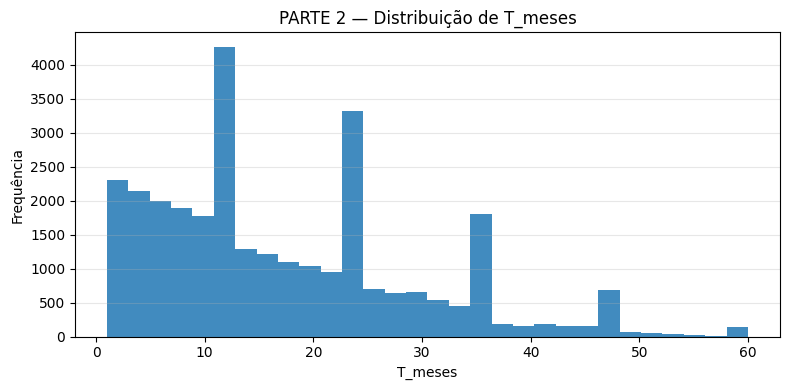

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df['T_meses'], bins=30, color='#1f77b4', alpha=0.85)
ax.set_title('PARTE 2 — Distribuição de T_meses')
ax.set_xlabel('T_meses')
ax.set_ylabel('Frequência')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### 2.4) Histograma de LTV

**O que ver:** dispersão de LTV e faixas extremas.


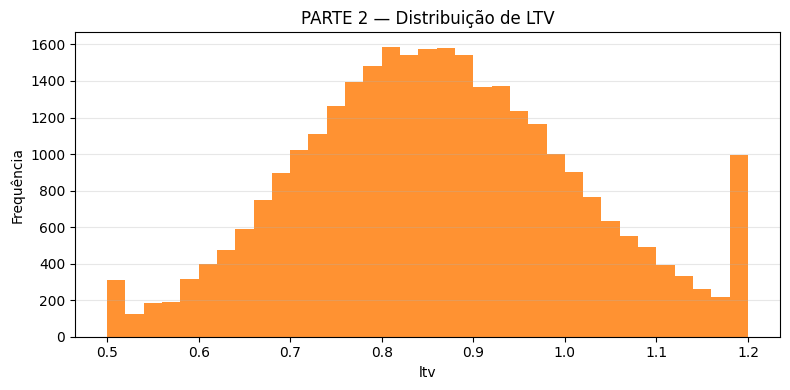

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df['ltv'], bins=35, color='#ff7f0e', alpha=0.85)
ax.set_title('PARTE 2 — Distribuição de LTV')
ax.set_xlabel('ltv')
ax.set_ylabel('Frequência')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### 2.5) Selic na originação ao longo do tempo

**O que ver:** mudança macro por coorte mensal de originação.


In [7]:
monthly_selic = df.groupby(df['orig_dt'].dt.to_period('M'))['selic_at_orig'].mean().reset_index()
monthly_selic['orig_dt'] = monthly_selic['orig_dt'].dt.to_timestamp()

fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_selic['orig_dt'], y=monthly_selic['selic_at_orig'], mode='lines', name='Selic média'))
fig.update_layout(
    title='PARTE 2 — Selic média na originação (mensal)',
    xaxis_title='orig_dt',
    yaxis_title='selic_at_orig'
)
fig.show()


plotly figure rendered (stub)


### 2.6) Tabela descritiva rápida

**O que ver:** faixa de LTV, Selic, spread e margem proxy.


In [8]:
desc_cols = ['ltv', 'selic_at_orig', 'rate_spread_m', 'margin_monthly_proxy']

df[desc_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
ltv,30000.0,0.863084,0.151929,0.500000,0.757978,0.857372,0.963122,1.200000
selic_at_orig,30000.0,9.139676,1.500441,5.000000,8.036654,9.019624,10.263934,12.984558
rate_spread_m,30000.0,0.007529,0.003410,-0.001620,0.005079,0.007484,0.009850,0.022414
margin_monthly_proxy,30000.0,707.257157,446.081315,42.887936,386.573355,606.224617,916.815346,4225.219128


## 3) Conceitos mínimos

- `T_meses`: tempo observado
- `E_prepay`: evento observado (1) vs censurado (0)
- **Censura não é zero**: significa que o evento não ocorreu até o corte observado


## 4) Kaplan–Meier global

Vamos ajustar KM para toda a carteira e gerar a curva executiva S(t).


### 4.1) Ajuste KM global

**O que:** fit com `T_meses` e `E_prepay`.  
**Por que:** obter S(t).  
**O que ver:** objeto ajustado pronto.


In [9]:
km_global = KaplanMeierFitter()
km_global.fit(df['T_meses'], event_observed=df['E_prepay'], label='KM Global')

print('KM global ajustado.')


KM global ajustado.


### 4.2) Construir tabela da curva S(t)

**O que ver:** colunas `t` e `S_t`.


In [10]:
km_global_df = km_global.survival_function_.reset_index()  # transforma curva em tabela

time_col = km_global_df.columns[0]  # identifica coluna de tempo (varia por versão)
value_col = km_global_df.columns[1]  # identifica coluna de S(t)

km_global_df = km_global_df.rename(columns={time_col: 't', value_col: 'S_t'})  # padroniza nomes

km_global_df.head(10)


,t,S_t
0,0.0,1.000000
1,1.0,0.974667
2,2.0,0.950662
3,3.0,0.927393
4,4.0,0.903367
5,5.0,0.880842
6,6.0,0.860716
7,7.0,0.838782
8,8.0,0.817318
9,9.0,0.798595


### 4.3) Curva KM global (Plotly)

**O que ver:** degraus de sobrevivência com marcação em 12 e 24 meses.


In [11]:
s12 = float(km_global.predict(12))
s24 = float(km_global.predict(24))

fig = go.Figure()
fig.add_trace(go.Scatter(x=km_global_df['t'], y=km_global_df['S_t'], mode='lines', name='S(t) Global', line_shape='hv'))
fig.add_trace(go.Scatter(x=[12, 24], y=[s12, s24], mode='markers', name='S(12), S(24)'))
fig.add_annotation(x=12, y=s12, text=f'S(12)={s12:.2%}', showarrow=True, arrowhead=2)
fig.add_annotation(x=24, y=s24, text=f'S(24)={s24:.2%}', showarrow=True, arrowhead=2)
fig.update_layout(title='PARTE 4 — KM Global S(t)', xaxis_title='t (meses)', yaxis_title='S(t)')
fig.show()


plotly figure rendered (stub)


### 4.4) Métricas executivas globais (inclui RMST36)

**O que ver:** S(12), S(24), mediana e RMST até 36 meses.


In [12]:
mediana_global = km_global.median_survival_time_
rmst36_global = float(np.trapezoid([float(km_global.predict(t)) for t in range(0, 37)], range(0, 37)))
mediana_txt = f'{mediana_global:.1f}' if np.isfinite(mediana_global) else 'Não atingiu 50%'

global_table = pd.DataFrame({
    'S(12)': [f'{s12:.2%}'],
    'S(24)': [f'{s24:.2%}'],
    'Mediana': [mediana_txt],
    'RMST36': [f'{rmst36_global:.2f}']
})

global_table


,S(12),S(24),Mediana,RMST36
0,73.67%,54.47%,28.0,23.58


## 5) KM por grupos (coração da aula)

Vamos comparar curvas para identificar sensibilidade de duração.


### 5.0) Funções auxiliares curtas

Vamos padronizar tabela de métricas por grupo.


In [13]:
def km_metrics(km_obj, group_name):
    s12 = float(km_obj.predict(12))
    s24 = float(km_obj.predict(24))
    med = km_obj.median_survival_time_
    rmst36 = float(np.trapezoid([float(km_obj.predict(t)) for t in range(0, 37)], range(0, 37)))
    med_txt = f'{med:.1f}' if np.isfinite(med) else 'Não atingiu 50%'
    return {
        'grupo': group_name,
        'S(12)': s12,
        'S(24)': s24,
        'mediana': med_txt,
        'RMST36': rmst36,
    }


### 5.1) Selic baixa (Q1) vs Selic alta (Q4)

**O que ver:** curva que cai mais rápido indica menor duração.


In [14]:
q1_selic = df['selic_at_orig'].quantile(0.25)
q4_selic = df['selic_at_orig'].quantile(0.75)

selic_low = df[df['selic_at_orig'] <= q1_selic].copy()
selic_high = df[df['selic_at_orig'] >= q4_selic].copy()

km_selic_low = KaplanMeierFitter().fit(selic_low['T_meses'], event_observed=selic_low['E_prepay'], label='Selic Q1 (baixa)')
km_selic_high = KaplanMeierFitter().fit(selic_high['T_meses'], event_observed=selic_high['E_prepay'], label='Selic Q4 (alta)')


Curvas KM para Selic baixa vs alta.


In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=km_selic_low.survival_function_.index, y=km_selic_low.survival_function_['Selic Q1 (baixa)'], mode='lines', name='Selic Q1', line_shape='hv'))
fig.add_trace(go.Scatter(x=km_selic_high.survival_function_.index, y=km_selic_high.survival_function_['Selic Q4 (alta)'], mode='lines', name='Selic Q4', line_shape='hv'))
fig.update_layout(title='PARTE 5 — KM por Selic (Q1 vs Q4)', xaxis_title='t (meses)', yaxis_title='S(t)')
fig.show()


plotly figure rendered (stub)


Tabela executiva de métricas por grupo de Selic.


In [16]:
selic_metrics_raw = pd.DataFrame([
    km_metrics(km_selic_low, 'Selic Q1 (baixa)'),
    km_metrics(km_selic_high, 'Selic Q4 (alta)'),
])

selic_metrics = selic_metrics_raw.copy()
selic_metrics['S(12)'] = selic_metrics['S(12)'].map(lambda x: f'{x:.2%}')
selic_metrics['S(24)'] = selic_metrics['S(24)'].map(lambda x: f'{x:.2%}')
selic_metrics['RMST36'] = selic_metrics['RMST36'].map(lambda x: f'{x:.2f}')

selic_metrics


,grupo,S(12),S(24),mediana,RMST36
0,Selic Q1 (baixa),62.99%,41.75%,19.0,19.87
1,Selic Q4 (alta),85.10%,72.09%,Não atingiu 50%,28.58


Leitura FP&A: diferença de curva por Selic muda expectativa de duração e planejamento.


### 5.2) LTV baixo vs LTV alto

Grupos: `ltv <= 0.75` e `ltv >= 0.95`.


In [17]:
ltv_low = df[df['ltv'] <= 0.75].copy()
ltv_high = df[df['ltv'] >= 0.95].copy()

km_ltv_low = KaplanMeierFitter().fit(ltv_low['T_meses'], event_observed=ltv_low['E_prepay'], label='LTV baixo')
km_ltv_high = KaplanMeierFitter().fit(ltv_high['T_meses'], event_observed=ltv_high['E_prepay'], label='LTV alto')


Curvas KM para LTV baixo vs alto.


In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=km_ltv_low.survival_function_.index, y=km_ltv_low.survival_function_['LTV baixo'], mode='lines', name='LTV baixo', line_shape='hv'))
fig.add_trace(go.Scatter(x=km_ltv_high.survival_function_.index, y=km_ltv_high.survival_function_['LTV alto'], mode='lines', name='LTV alto', line_shape='hv'))
fig.update_layout(title='PARTE 5 — KM por LTV (baixo vs alto)', xaxis_title='t (meses)', yaxis_title='S(t)')
fig.show()


plotly figure rendered (stub)


Tabela executiva de métricas por grupo de LTV.


In [19]:
ltv_metrics_raw = pd.DataFrame([
    km_metrics(km_ltv_low, 'LTV baixo'),
    km_metrics(km_ltv_high, 'LTV alto'),
])

ltv_metrics = ltv_metrics_raw.copy()
ltv_metrics['S(12)'] = ltv_metrics['S(12)'].map(lambda x: f'{x:.2%}')
ltv_metrics['S(24)'] = ltv_metrics['S(24)'].map(lambda x: f'{x:.2%}')
ltv_metrics['RMST36'] = ltv_metrics['RMST36'].map(lambda x: f'{x:.2f}')

ltv_metrics


,grupo,S(12),S(24),mediana,RMST36
0,LTV baixo,67.99%,46.99%,22.0,21.54
1,LTV alto,78.44%,61.47%,34.0,25.47


Leitura FP&A: grupos com S(t) mais alto tendem a manter saldo por mais tempo.


### 5.3) Spread baixo vs Spread alto

Usaremos `rate_spread_m` por quantis Q1 vs Q4.


In [20]:
q1_spread = df['rate_spread_m'].quantile(0.25)
q4_spread = df['rate_spread_m'].quantile(0.75)

spread_low = df[df['rate_spread_m'] <= q1_spread].copy()
spread_high = df[df['rate_spread_m'] >= q4_spread].copy()

km_spread_low = KaplanMeierFitter().fit(spread_low['T_meses'], event_observed=spread_low['E_prepay'], label='Spread Q1 (baixo)')
km_spread_high = KaplanMeierFitter().fit(spread_high['T_meses'], event_observed=spread_high['E_prepay'], label='Spread Q4 (alto)')


Curvas KM para spread baixo vs alto.


In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=km_spread_low.survival_function_.index, y=km_spread_low.survival_function_['Spread Q1 (baixo)'], mode='lines', name='Spread Q1', line_shape='hv'))
fig.add_trace(go.Scatter(x=km_spread_high.survival_function_.index, y=km_spread_high.survival_function_['Spread Q4 (alto)'], mode='lines', name='Spread Q4', line_shape='hv'))
fig.update_layout(title='PARTE 5 — KM por Spread (Q1 vs Q4)', xaxis_title='t (meses)', yaxis_title='S(t)')
fig.show()


plotly figure rendered (stub)


Tabela executiva de métricas por grupo de spread.


In [22]:
spread_metrics_raw = pd.DataFrame([
    km_metrics(km_spread_low, 'Spread Q1 (baixo)'),
    km_metrics(km_spread_high, 'Spread Q4 (alto)'),
])

spread_metrics = spread_metrics_raw.copy()
spread_metrics['S(12)'] = spread_metrics['S(12)'].map(lambda x: f'{x:.2%}')
spread_metrics['S(24)'] = spread_metrics['S(24)'].map(lambda x: f'{x:.2%}')
spread_metrics['RMST36'] = spread_metrics['RMST36'].map(lambda x: f'{x:.2f}')

spread_metrics


,grupo,S(12),S(24),mediana,RMST36
0,Spread Q1 (baixo),71.21%,51.23%,25.0,22.66
1,Spread Q4 (alto),76.25%,57.94%,31.0,24.57


Leitura FP&A: alteração de spread pode deslocar velocidade de prepay e duração efetiva.


## 6) Impacto em NII (proxy simples)

Definição didática:
`NII proxy (36m) = Σ_{t=1..36} S(t) * margin_monthly_proxy`

Na prática abaixo, usamos: `NII_proxy_36m = RMST36 * margem_média_mensal`.


### 6.1) Tabela executiva final por grupo

**O que ver:** grupo, RMST36, NII proxy e métricas de sobrevivência.


In [23]:
def nii_proxy_row(km_obj, group_name, margin_mean):
    met = km_metrics(km_obj, group_name)
    med = met['mediana']
    med_txt = med if isinstance(med, str) else f'{med:.1f}'
    nii36 = met['RMST36'] * margin_mean
    return {
        'grupo': group_name,
        'S(12)': met['S(12)'],
        'S(24)': met['S(24)'],
        'mediana': med_txt,
        'RMST36': met['RMST36'],
        'NII_proxy_36m': nii36,
    }


Agora montamos os grupos principais (Selic e LTV) para comparar NII proxy.


In [24]:
nii_rows = [
    nii_proxy_row(km_selic_low, 'Selic baixa', selic_low['margin_monthly_proxy'].mean()),
    nii_proxy_row(km_selic_high, 'Selic alta', selic_high['margin_monthly_proxy'].mean()),
    nii_proxy_row(km_ltv_low, 'LTV baixo', ltv_low['margin_monthly_proxy'].mean()),
    nii_proxy_row(km_ltv_high, 'LTV alto', ltv_high['margin_monthly_proxy'].mean()),
]

nii_exec_raw = pd.DataFrame(nii_rows)
nii_exec = nii_exec_raw.copy()
nii_exec['S(12)'] = nii_exec['S(12)'].map(lambda x: f'{x:.2%}')
nii_exec['S(24)'] = nii_exec['S(24)'].map(lambda x: f'{x:.2%}')
nii_exec['RMST36'] = nii_exec['RMST36'].map(lambda x: f'{x:.2f}')
nii_exec['NII_proxy_36m'] = nii_exec_raw['NII_proxy_36m'].map(lambda x: f'R$ {x:,.0f}')

nii_exec


,grupo,S(12),S(24),mediana,RMST36,NII_proxy_36m
0,Selic baixa,62.99%,41.75%,19.0,19.87,"R$ 12,142"
1,Selic alta,85.10%,72.09%,Não atingiu 50%,28.58,"R$ 23,166"
2,LTV baixo,67.99%,46.99%,22.0,21.54,"R$ 10,053"
3,LTV alto,78.44%,61.47%,34.0,25.47,"R$ 24,593"


### 6.2) Barras de NII proxy por grupo

**O que ver:** diferença de NII proxy entre cenários/grupos.


In [25]:
fig = px.bar(nii_exec_raw, x='grupo', y='NII_proxy_36m', color='grupo', text='NII_proxy_36m')
fig.update_traces(texttemplate='R$ %{text:,.0f}', textposition='outside', showlegend=False)
fig.update_layout(title='PARTE 6 — NII proxy 36m por grupo', xaxis_title='Grupo', yaxis_title='NII_proxy_36m (R$)')
fig.show()


plotly figure rendered (stub)


## 7) Validação temporal (treino vs teste)

Split temporal:
- Treino: até 2022-12-31
- Teste: 2023–2024


### 7.1) Ajustar KM em treino e teste temporal

**O que ver:** duas curvas para comparar possível mudança de regime.


In [26]:
cutoff_date = pd.Timestamp('2022-12-31')

train_time = df[df['orig_dt'] <= cutoff_date].copy()
test_time = df[df['orig_dt'] > cutoff_date].copy()

km_train = KaplanMeierFitter().fit(train_time['T_meses'], event_observed=train_time['E_prepay'], label='Treino <=2022')
km_test = KaplanMeierFitter().fit(test_time['T_meses'], event_observed=test_time['E_prepay'], label='Teste 2023-2024')


Curvas treino vs teste no mesmo gráfico.


In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=km_train.survival_function_.index, y=km_train.survival_function_['Treino <=2022'], mode='lines', name='Treino <=2022', line_shape='hv'))
fig.add_trace(go.Scatter(x=km_test.survival_function_.index, y=km_test.survival_function_['Teste 2023-2024'], mode='lines', name='Teste 2023-2024', line_shape='hv'))
fig.update_layout(title='PARTE 7 — KM Treino vs Teste temporal', xaxis_title='t (meses)', yaxis_title='S(t)')
fig.show()


plotly figure rendered (stub)


Tabela comparativa treino vs teste.


In [28]:
time_raw = pd.DataFrame([
    km_metrics(km_train, 'Treino <=2022'),
    km_metrics(km_test, 'Teste 2023-2024'),
])

time_view = time_raw.copy()
time_view['S(12)'] = time_view['S(12)'].map(lambda x: f'{x:.2%}')
time_view['S(24)'] = time_view['S(24)'].map(lambda x: f'{x:.2%}')
time_view['RMST36'] = time_view['RMST36'].map(lambda x: f'{x:.2f}')

time_view


,grupo,S(12),S(24),mediana,RMST36
0,Treino <=2022,71.47%,52.51%,26.0,22.96
1,Teste 2023-2024,79.44%,61.68%,Não atingiu 50%,26.55


Interpretação: diferenças entre treino e teste indicam mudança de regime e necessidade de monitoramento contínuo.


## 8) Conclusões executivas + checklist FP&A

- KM é uma curva executiva para discutir **quando** o prepay ocorre.
- Reporte mínimo recomendado: **S(12), S(24), mediana, RMST36**.
- Selic, LTV e spread mudam a inclinação da curva e a duração esperada.
- Duração menor pode reduzir juros futuros e alterar planejamento (proxy de NII).
- Split temporal é obrigatório para evitar visão otimista do passado.
- Governança: documentar hipótese, monitorar drift macro e reavaliar segmentações.

### Checklist FP&A (1 minuto)
- Evento e censura definidos corretamente?
- Curva KM global e por grupos revisada?
- Métricas S(12), S(24), mediana e RMST36 reportadas?
- Sensibilidades macro/LTV/spread avaliadas?
- Validação temporal treino vs teste concluída?
